In [1]:
from datetime import datetime
from functools import partial
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import numpy as np
import joblib

from wandb_utils import get_wandb_history
from plotting import plot_metric, plot_multi_validator_metric
from utils import average_challenges_per_tempo
from simulator import run_simulation

[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


## Query W&B or Load Locally Cached Data

In [2]:
# `load_cached_history` = True will read local pickle file at fname
# `load_cached_history` = False will query W&B
load_cached_history = True  
fname = 'vali_histories.pkl'

#  Earlist time (epoch) from which to pull W&B runs
start_ts = 1727846400

# Names of W&B runs to query
VALIDATORS = ['validator-193-1.1.0', 'validator-19-1.1.0', 'validator-107-1.1.0']

# Keys will be validator names, values will be history dataframes
HISTORY_DFS = {}


In [3]:
if load_cached_history:
    HISTORY_DFS = joblib.load(fname)
else:
    for vali in VALIDATORS:
        print(f"Loading data from {vali}")
        HISTORY_DFS[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=None, 
            verbosity=0)

    joblib.dump(HISTORY_DFS, fname)

for vali, history_df in HISTORY_DFS.items():
    print(vali)
    avg, counts = average_challenges_per_tempo(history_df)
    format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
    print(f'\tDate Range: {format_time(history_df._timestamp.min())} : {format_time(history_df._timestamp.max())}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')
    

validator-193-1.1.0
	Date Range: 2024-10-02T02:37:00 : 2024-10-02T21:03:35
	DataFrame shape: (897, 4)
	Average Challenges Per Tempo: 56.0625
		Challenges Per Tempo: [60, 60, 59, 59, 60, 58, 60, 59, 58, 59, 57, 53, 56, 58, 58, 23]
validator-19-1.1.0
	Date Range: 2024-10-02T04:29:51 : 2024-10-02T20:59:16
	DataFrame shape: (739, 4)
	Average Challenges Per Tempo: 52.785714285714285
		Challenges Per Tempo: [53, 56, 56, 51, 55, 50, 57, 54, 55, 54, 50, 52, 55, 41]
validator-107-1.1.0
	Date Range: 2024-10-02T02:33:06 : 2024-10-02T21:05:43
	DataFrame shape: (816, 4)
	Average Challenges Per Tempo: 51.0
		Challenges Per Tempo: [57, 52, 54, 52, 52, 56, 54, 54, 50, 50, 54, 48, 49, 56, 53, 25]


## Run Simulation or Load Simulation Results

In [4]:
# `load_cached_scores` = False will run simulations for each validator with the specified reward functions in parallel
# `load_cached_scores` = True will read local pickle file
load_cached_scores = False  

# `write_to_cache` = True will overwrite scored_fname
write_to_cache = False
scored_fname = 'histories_scored.pkl'

# Number of dataframe rows over which to compute rewards and scores, set to `None` for all rows
score_num_challenges = Non

# Keys are validator (w&b run) names, values are dataframes with reward & score columns
SCORED_DFS = {}

In [5]:
if load_cached_scores:
    SCORED_DFS = joblib.load(scored_fname)
else:  
    simulation_fn = partial(run_simulation, limit=score_num_challenges)

    # progress bar is kinda jank with multiprocessing, could fix but nah
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(
            simulation_fn,
            [HISTORY_DFS[vali] for vali in VALIDATORS])
    
    SCORED_DFS = {vali: scored_df for vali, scored_df in zip(VALIDATORS, results)}
    if write_to_cache:
        joblib.dump(SCORED_DFS, scored_fname)

functools.partial(<function run_simulation at 0x7f71fc391870>, limit=5)


Computing Rewards and Scores: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


## Plot Rewards and Scores 
**Note: Variable y-axis ranges**

Todo: update x axis to be human readable timestamp 

## reward100 * .5 + reward10 * .25 + correct * .25

In [6]:
uids = [226, 179, 172]#, 39]
start_idx = -100
end_idx = -1

### Inspect Same Miner over Multiple Validators

#### Scores

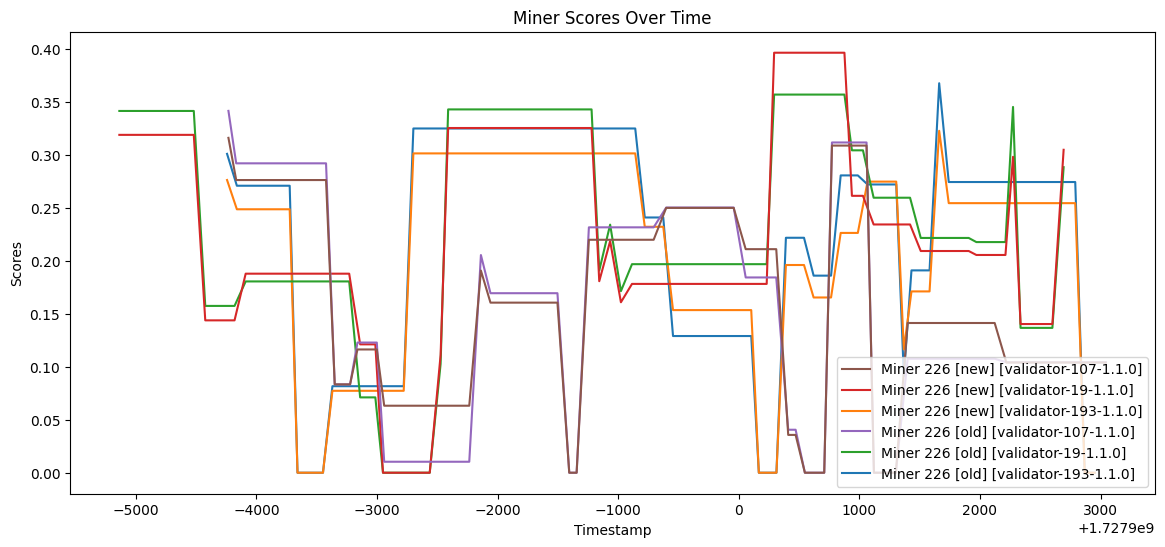

In [14]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='scores', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower right')

#### Rewards

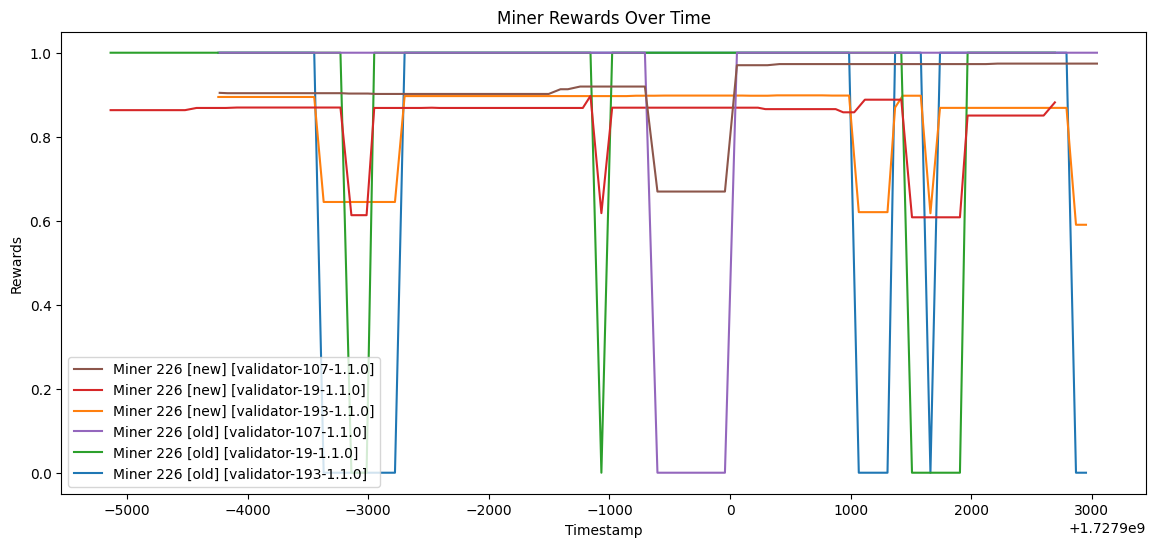

In [15]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='rewards', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower left')

### Inspect Individual Validators

validator-193-1.1.0


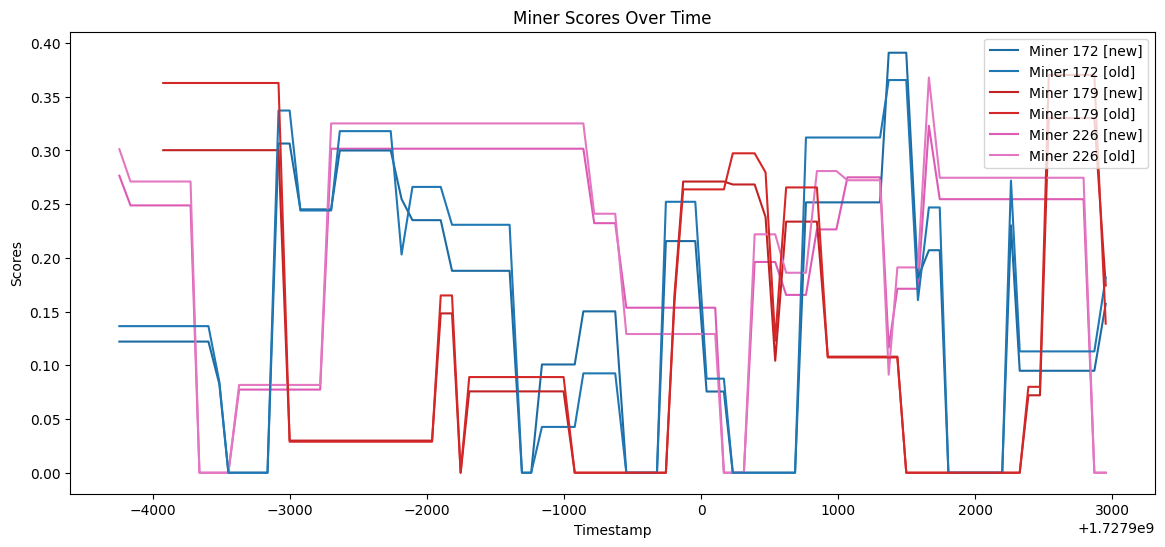

validator-19-1.1.0


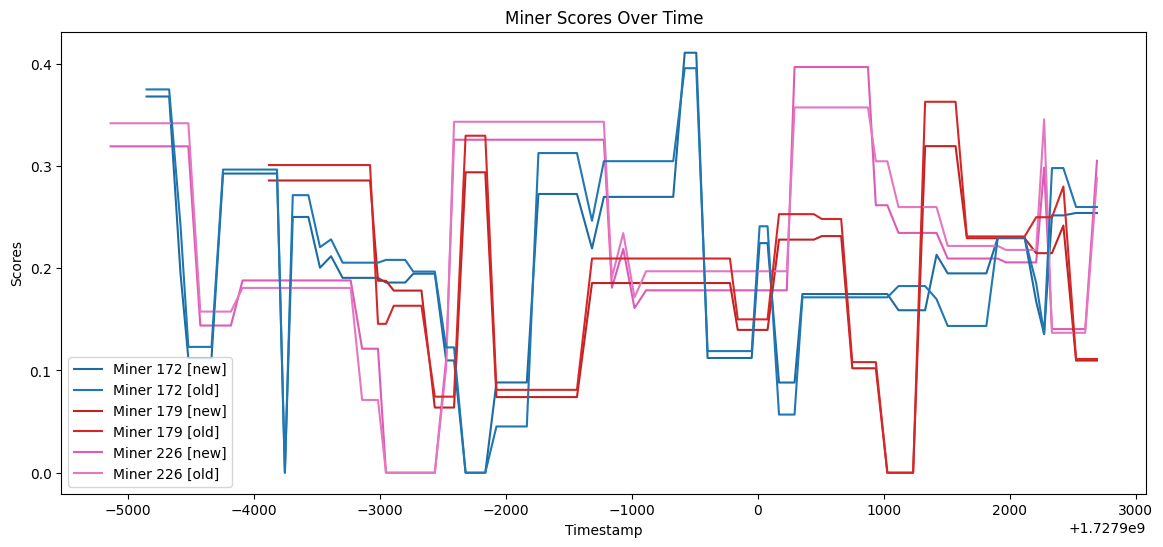

validator-107-1.1.0


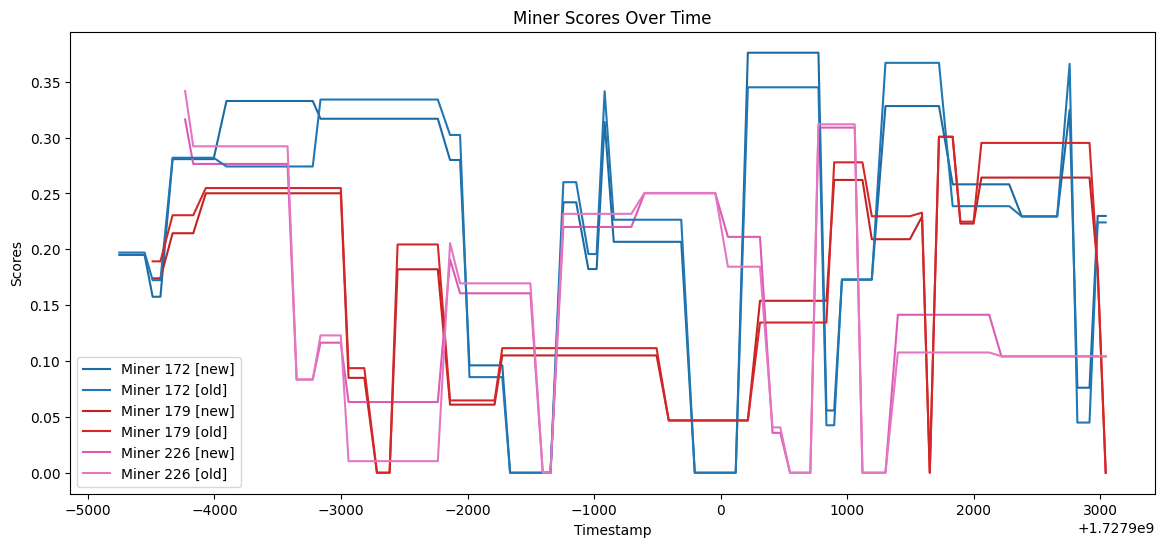

In [20]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=True)


validator-193-1.1.0


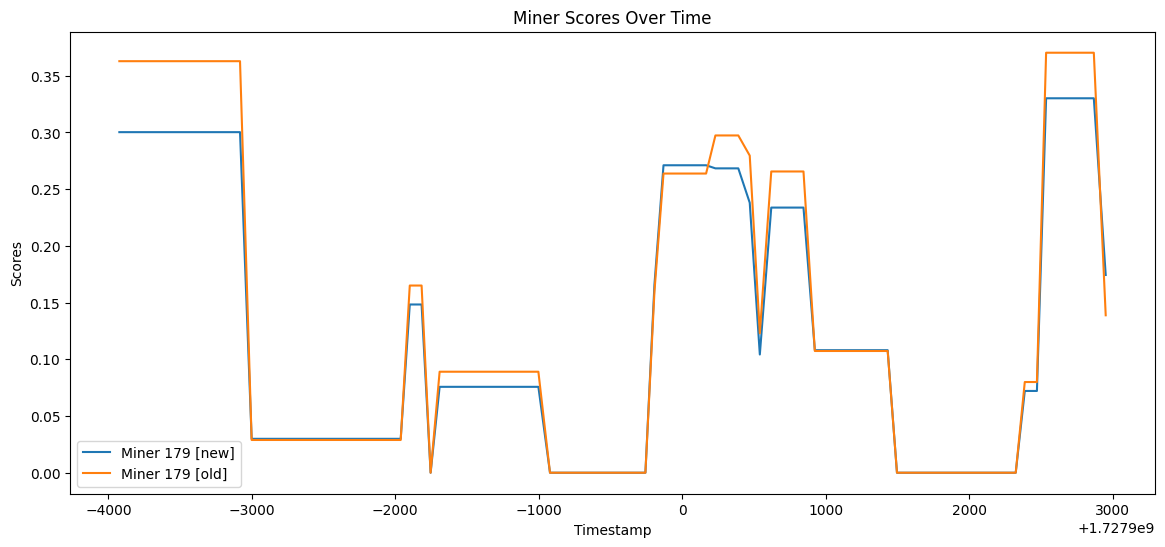

validator-19-1.1.0


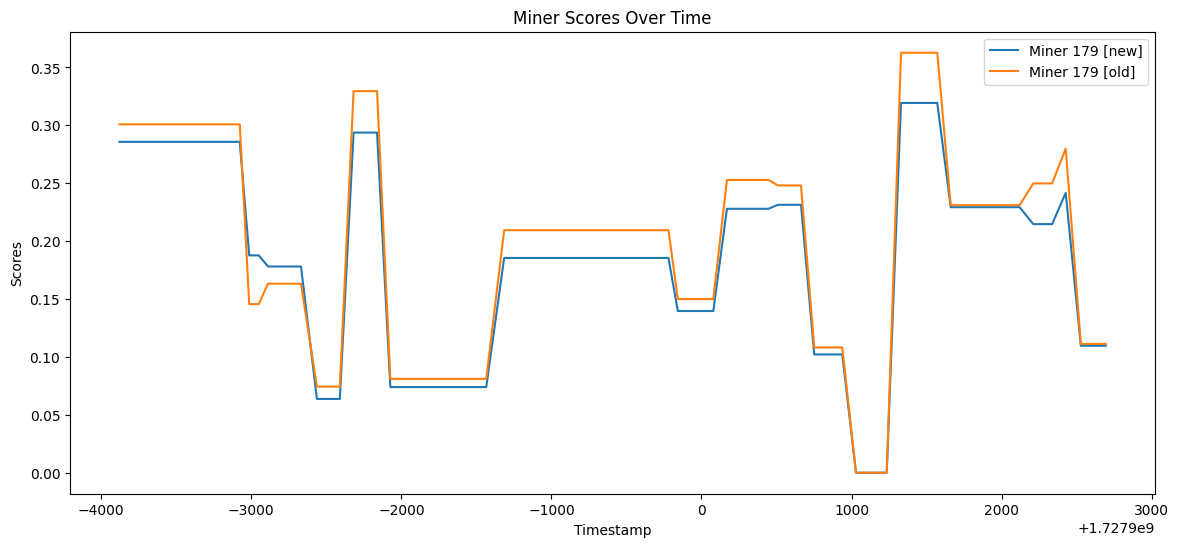

validator-107-1.1.0


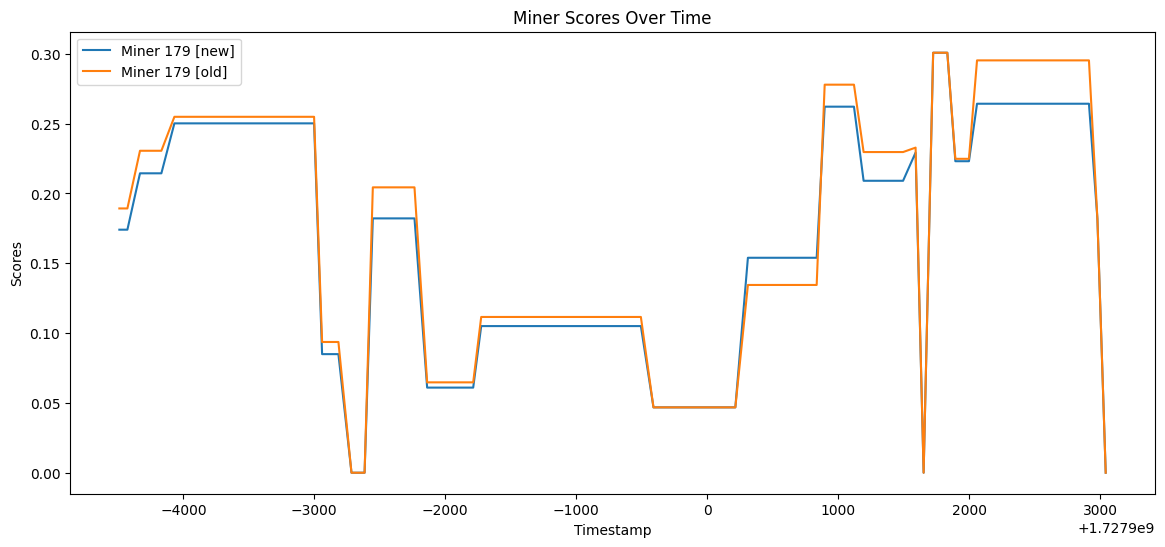

In [21]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=[uids[1]], suffixes=['new', 'old'], map_uids_to_colors=False)


## ---------- Older Results (pre-multivalidator plotting) ----------

## reward100 * .5 + reward10 * .25 + correct * .25

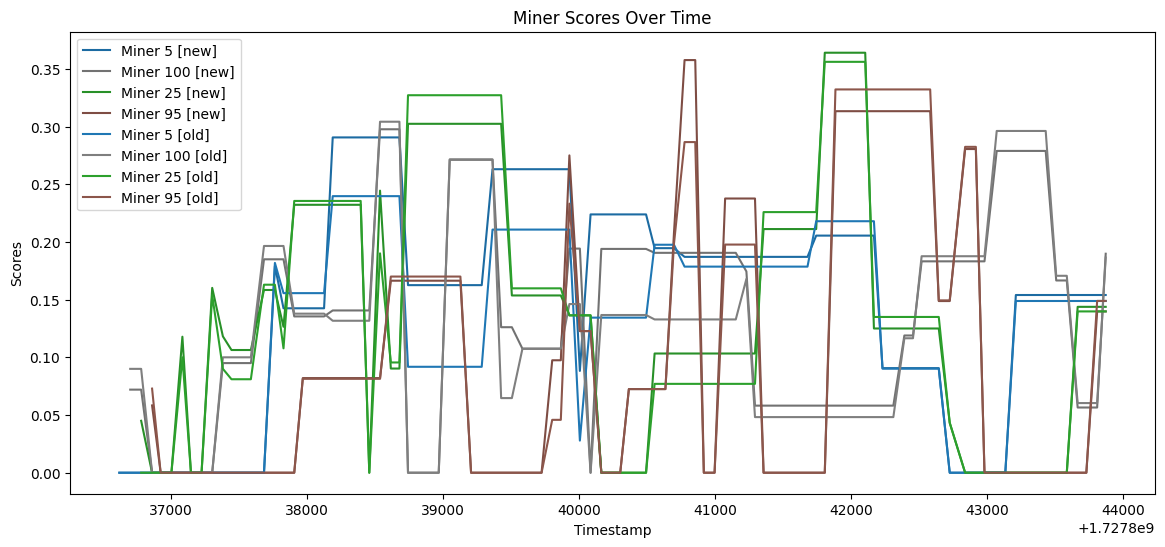

In [11]:
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=map_uids_to_colors)


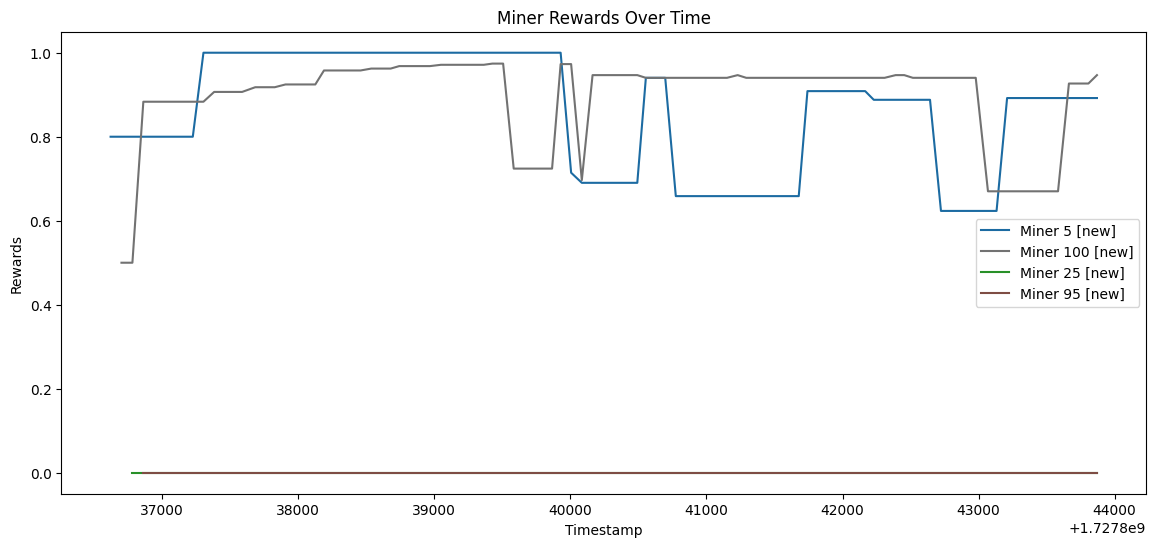

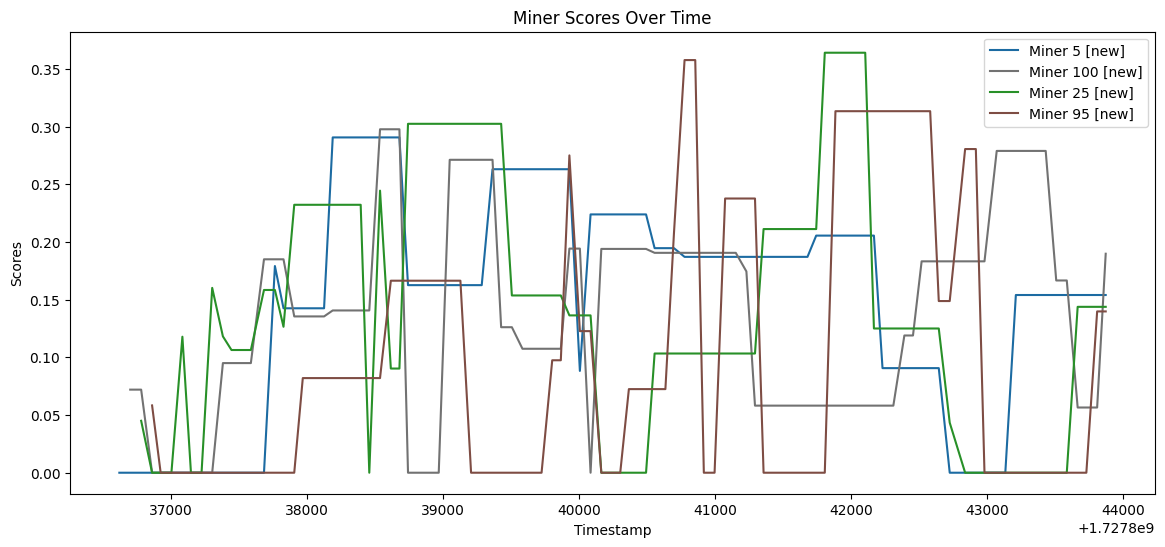

In [9]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)


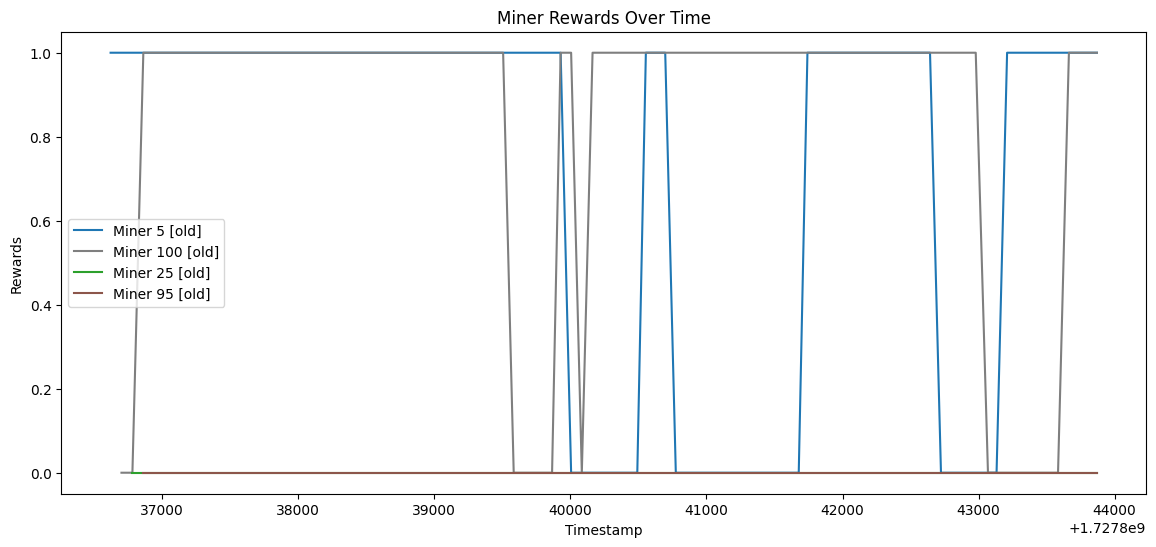

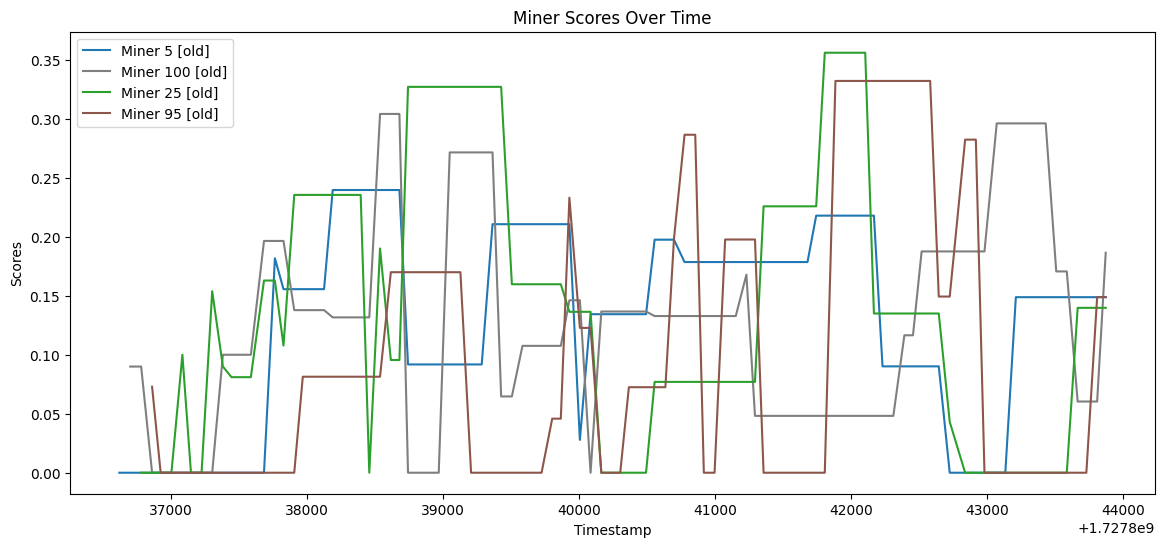

In [10]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)


## reward10 * .2 + correct * .8

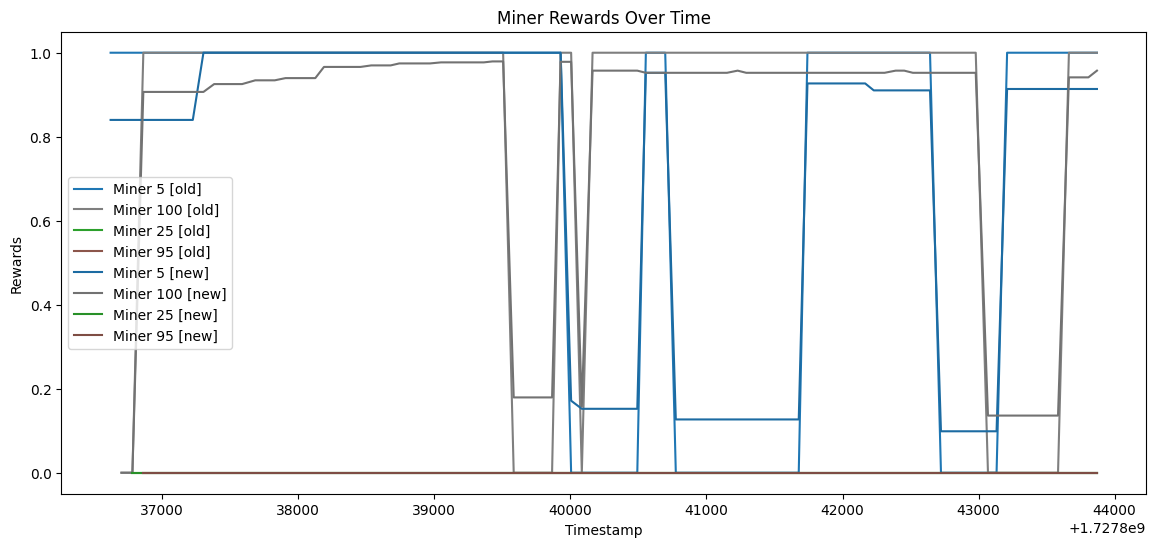

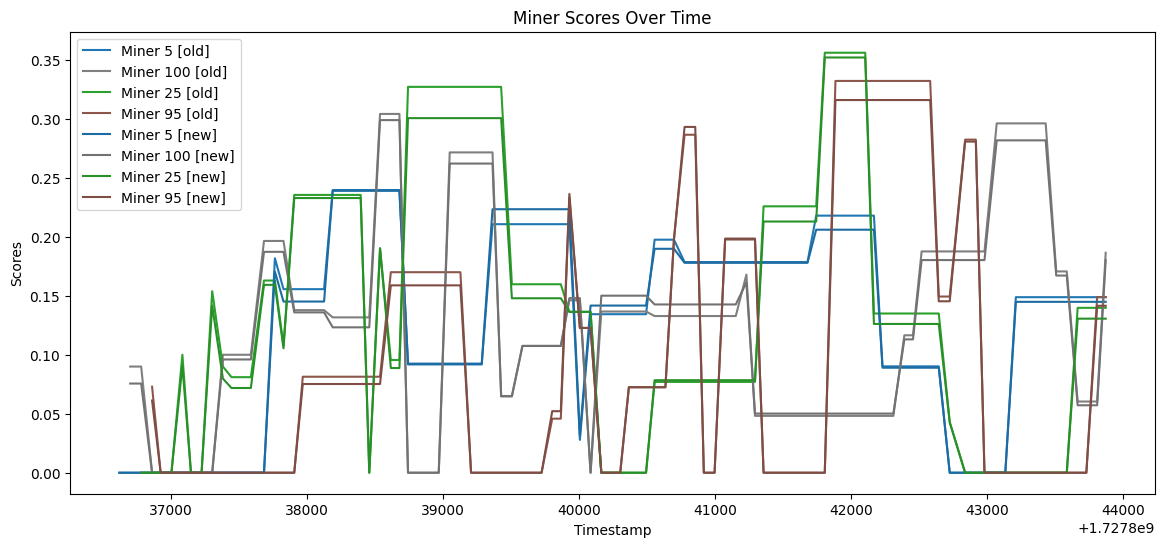

In [43]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, map_uids_to_colors=map_uids_to_colors)
